The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


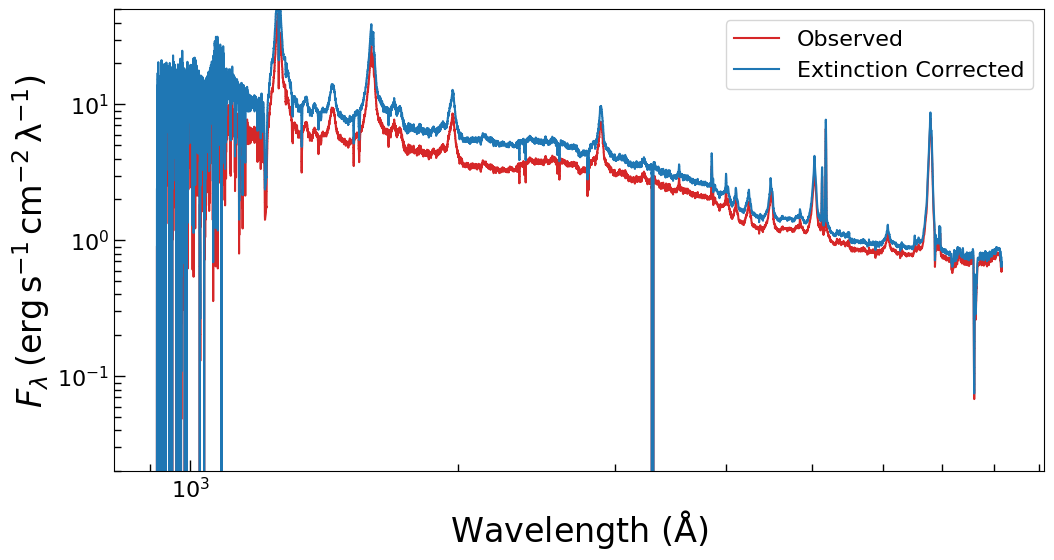

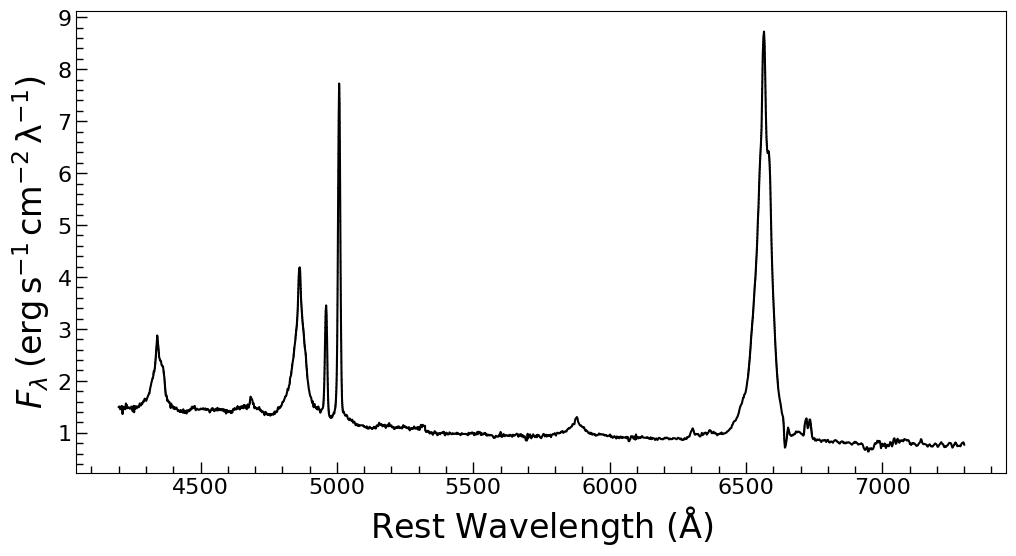

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s

datapath = 'data'
hdul = fits.open('mrk509sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.157    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()

zred = 0.0345 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7300
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

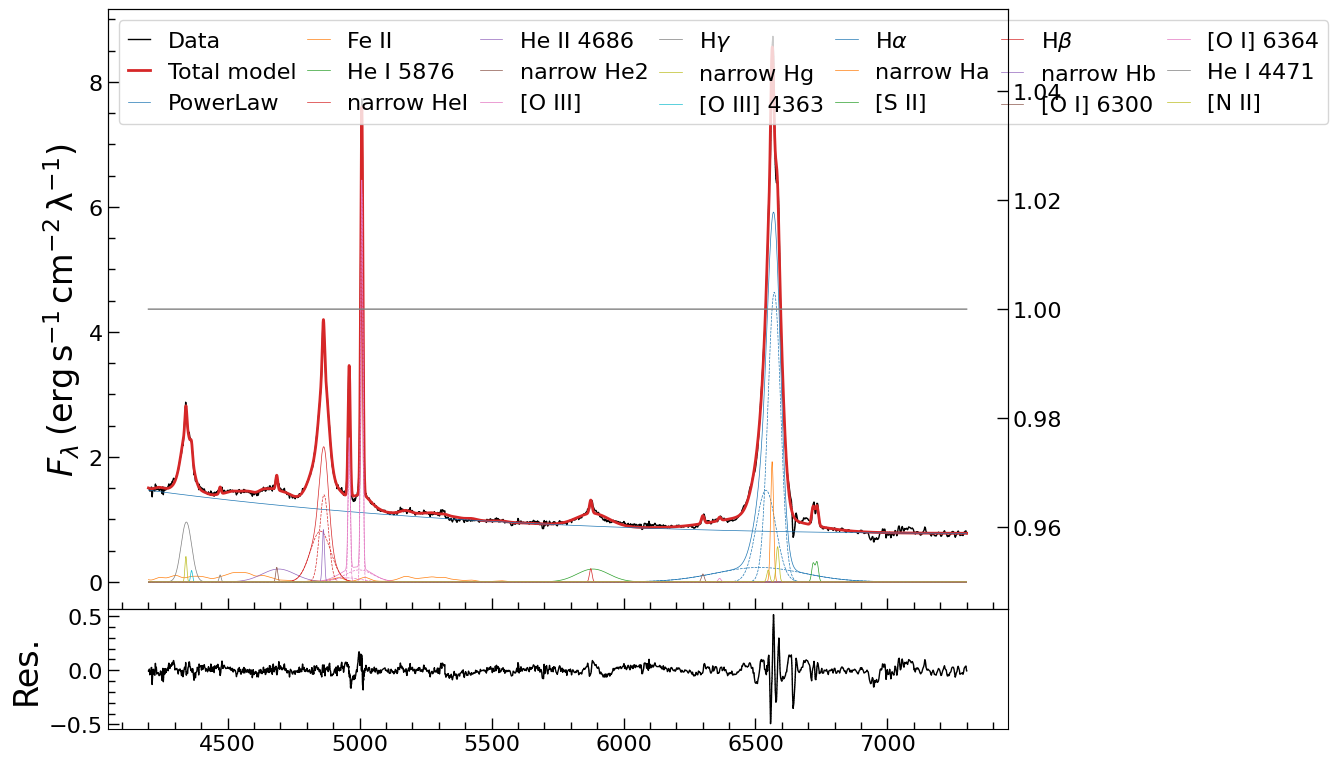

<PowerLaw1D(amplitude=1.35591546, x_0=5500., alpha=0.81893855, name='PowerLaw')>
<IronTemplate(amplitude=0.25283299, stddev=1215.0799, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.29587729, dv_c=449.58395418, sigma_c=3089.38083518, wavec=5875.624, name='He I 5876')>
<Line_Gaussian(amplitude=0.30562699, dv=10.80674575, sigma=250.73913623, wavec=5875.624, name='narrow HeI')>
<Line_MultiGauss(amp_c=0.2588901, dv_c=500., sigma_c=4000., wavec=4686., name='He II 4686')>
<Line_Gaussian(amplitude=0.29327766, dv=10.80674575, sigma=250.73913623, wavec=4686., name='narrow He2')>
<Line_MultiGauss_doublet(amp_c0=8.20575673, amp_c1=2.75360964, dv_c=10.80674575, sigma_c=250.73913623, wavec0=5008.239, wavec1=4960.295, amp_w0=0.03070895, dv_w0=-583.08548728, sigma_w0=3148.47222817, name='[O III]')>
<Line_MultiGauss(amp_c=1.13362073, dv_c=137.55271934, sigma_c=1391.71038891, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.48155164, dv=10.80674575, sigma=250.73913623, wavec=4341.785, name

In [11]:
#------------------------------------------------------------具体拟合，修改各成分
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=2, name='multi') 
pl = models.PowerLaw1D(amplitude=1.35591546, x_0=5500, alpha=0.81893855, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')
iron = sagan.IronTemplate(amplitude=0.25283299, stddev=1215.0799, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.99, dv_c=130, sigma_c=1500, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=1.6, dv_c=-1000, sigma_c=1700, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.18, dv_w0=-40, sigma_w0=2300,amp_w1=3.09845478, 
                             dv_w1=1389.31411282, sigma_w1=1063.70304222)
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=1.3, dv_c=100, sigma_c=970, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.65, dv_w0=-320, sigma_w0=2300, bounds=bounds)
'''
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=5.2, dv_c=280, sigma_c=1000, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.26, dv_w0=-1300, sigma_w0=2400)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=1.3, dv_c=73, sigma_c=930, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.63, dv_w0=-240, sigma_w0=2300, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.97, dv_c=140, sigma_c=1300, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
'''
bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.215, dv_c=240, sigma_c=1400, wavec=5875.624, name='He I 5876')
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.2, dv_c=-500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=6, amp_c1=2, dv_c=10, sigma_c=240, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.09, dv_w0=130, sigma_w0=800)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.43, amp_c1=0.44,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=5, amp_c1=5, dv_c=-20, sigma_c=200,
                                       wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')
'''
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.09, dv_c=-500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.26, dv_c=200, sigma_c=1000, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=4.7, amp_c1=1.6, dv_c=75, sigma_c=210, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.48, dv_w0=-250, sigma_w0=200, amp_w1=0.09, dv_w1=-30, sigma_w1=900)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.51, amp_c1=0.48,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
#line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=5, amp_c1=5, dv_c=-20, sigma_c=200,
#                                       wavec0=wave_dict['NII_6548'], wavec1=wave_dict['NII_6583'], name='[N II]')
'''
n_he1= sagan.Line_Gaussian(amplitude=0.11, wavec=5875.624, name='narrow HeI')  # Masked
n_he2 = sagan.Line_Gaussian(amplitude=0.21, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_hg = sagan.Line_Gaussian(amplitude=0.44, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.17, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_ha = sagan.Line_Gaussian(amplitude=1.4, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.8, wavec=wave_dict['Hbeta'], name=f'narrow Hb')


n_o1_6300 = sagan.Line_Gaussian(amplitude=0.23, wavec=wave_dict['OI_6300'], name=f'[O I] 6300')
n_o1_6364 = sagan.Line_Gaussian(amplitude=0.18, wavec=wave_dict['OI_6364'], name=f'[O I] 6364')
n_fe10_6375 = sagan.Line_Gaussian(amplitude=0.16, wavec=wave_dict['FeX_6375'], name=f'[Fe X] 6375')
n_he1_4471 = sagan.Line_Gaussian(amplitude=0.15, wavec=wave_dict['HeI_4471'], name=f'He I 4471')
'''
n_ha = sagan.Line_Gaussian(amplitude=1.58, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.76, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.35, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.25, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.19, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
'''

line_he1 =  b_he1+n_he1
line_he2 =  b_he2 + n_he2
line_hg  =  b_hg + n_hg
line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
'''
line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked
'''
m_init = (pl +iron +line_he1+ line_he2 +line_o3 +line_hg+n_o3_4363+line_ha+line_s2+line_hb+n_o1_6300+n_o1_6364+n_he1_4471+line_n2)*poly
# +line_he1+ line_he2 +line_o3 +line_hg+n_o3_4363+line_ha+line_s2+line_hb+n_o1_6300+n_o1_6364+n_he1_4471


# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hg, n_he2, n_o3_4363,n_he1,n_hb,n_o1_6300,n_o1_6364,n_he1_4471]:#n_fe10_6375
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr11 = (wave_use > 4260) & (wave_use < 4430)
fltr12 = (wave_use > 4600) & (wave_use < 5080)
fltr13 = (wave_use > 5550) & (wave_use < 6050)
fltr14 = (wave_use > 6200) & (wave_use < 6890)

#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())